# Coweeta Mixed-elements Mesh

This workflow provides a complete working example to develop an mixed-element mesh for an integrated hydrologic model at the Coweeta watershed. The river-network is explicitely defined by quad elements. We can also manipulate the elevation in the river-corridor if the land-surface-depression in the river corridor are not sufficiently captured. In this example, we do not mamnipulate any elevations.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `GLYHMPS` geology data for structural formations
* `SoilGrids 2017` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

This workflow creates the following files:

* Mesh file: `coweeta_mixed.exo`, includes all labeled sets

In [1]:
# conda package imports
import os,sys
import numpy as np
import shapely
import logging
import scipy.ndimage
from matplotlib import pyplot as plt
import h5py
import pandas
import xarray as xr
import copy
pandas.options.display.max_columns = None

# Watershed Workflow
import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.densify_rivers_hucs
import workflow.condition
import workflow.mesh
import workflow.split_hucs
import workflow.soil_properties
import workflow.daymet
import workflow.triangulation_with_streams
from workflow.triangulation import Nodes, NodesEdges

workflow.ui.setup_logging(1,None)

In [2]:
# specify the input shapefile and a hint as to what HUC it is in.
coweeta_shapefile = '../input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape

crs = workflow.crs.daymet_crs()
output_folder = "../workflow_output"

def get_filename(myfile):
    return os.path.join(output_folder, myfile)

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)


In [3]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [4]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [5]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']
workflow.source_list.log_sources(sources)

2021-10-29 13:00:17,132 - root - INFO: Using sources:
2021-10-29 13:00:17,133 - root - INFO: --------------
2021-10-29 13:00:17,133 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-10-29 13:00:17,134 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-10-29 13:00:17,134 - root - INFO: DEM: National Elevation Dataset (NED)
2021-10-29 13:00:17,135 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-10-29 13:00:17,135 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-10-29 13:00:17,136 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-10-29 13:00:17,136 - root - INFO: soil thickness: None
2021-10-29 13:00:17,137 - root - INFO: meteorology: DayMet 1km


### Get HUCs

In [6]:
# load the shape
_, watershed = workflow.get_split_form_shapes(coweeta_shapefile, out_crs=crs)
watershed_=copy.deepcopy(watershed) # keeping the original for re-densification

2021-10-29 13:00:18,525 - root - INFO: 
2021-10-29 13:00:18,526 - root - INFO: Loading shapes
2021-10-29 13:00:18,527 - root - INFO: ------------------------------
2021-10-29 13:00:18,527 - root - INFO: Loading file: '../input_data/coweeta_basin.shp'
2021-10-29 13:00:18,540 - root - INFO: ... found 1 shapes
2021-10-29 13:00:18,541 - root - INFO: Converting to shapely
2021-10-29 13:00:18,551 - root - INFO: Converting to requested CRS


### Get Rivers 

In [7]:
simplify = 30 # length scale to target average edge

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], hint, 
                                      watershed.exterior().bounds, crs, crs)
    
    # for the river network
    rivers_original = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=0.01, 
                                         snap=True, cut_intersections=True)
    
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, 
                                         snap=True, cut_intersections=True)


else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)

2021-10-29 13:00:19,642 - root - INFO: 
2021-10-29 13:00:19,643 - root - INFO: Loading Hydrography
2021-10-29 13:00:19,643 - root - INFO: ------------------------------
2021-10-29 13:00:19,644 - root - INFO: Loading streams in HUC 0601
2021-10-29 13:00:19,644 - root - INFO:          and/or bounds (1442132.8431974074, -650282.048183706, 1447117.7928619592, -645090.2638397965)
2021-10-29 13:00:27,171 - root - INFO:   REST query with polyCode... SUCCESS
2021-10-29 13:00:27,171 - root - INFO:   REST query: https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHDPlusHR/Beta/GDB/NHDPLUS_H_0601_HU4_GDB.zip
2021-10-29 13:00:27,172 - root - INFO: Downloading: "https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHDPlusHR/Beta/GDB/NHDPLUS_H_0601_HU4_GDB.zip"
2021-10-29 13:00:27,173 - root - INFO:          to: "/Users/7s2/Installations/ww_testing/watershed-workflow/examples/Coweeta/scripts/data/hydrography/NHDPlus_H_0601_GDB/raw/NHDPLUS_H_0601_HU4_GDB.zip"
2021-10-29 13:00:27,173 -

### Plotting original and simplified-pruned rivers and watershed


/Users/7s2/opt/anaconda3/envs/watershed_workflow_210126/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


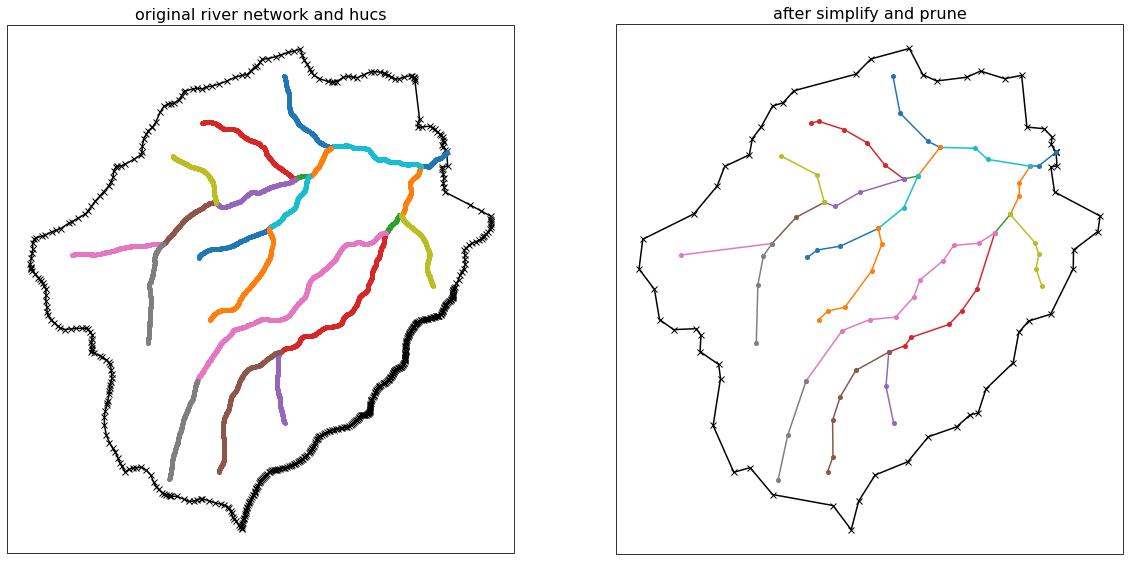

In [8]:
river_=rivers_original[0]
river=rivers[0]

plt.rcParams['figure.figsize'] = [20, 20]

fig, axs = plt.subplots(1,2,subplot_kw={'projection':workflow.crs.to_cartopy(crs)})

axs[0].plot(watershed_.exterior().exterior.xy[0], watershed_.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)

for node in river_.preOrder():
    x,y=node.segment.xy # node.segment gives us LS
    axs[0].plot(x,y,'-o',markersize=4)

for node in river.preOrder():
    x,y=node.segment.xy # node.segment gives us LS
    axs[1].plot(x,y,'-o',markersize=4)

### Densification of River Network and Watershed

In [9]:
#densify_watershed
watershed_densified=workflow.densify_rivers_hucs.DensifyHucs(watershed, watershed_, limit=400) # maximum length of section on huc boundary = 400 m

#densify_river
river_densified=workflow.densify_rivers_hucs.DensifyTree(river, river_, limit=200, collinear=True) # maximum length of section on river network = 200 m

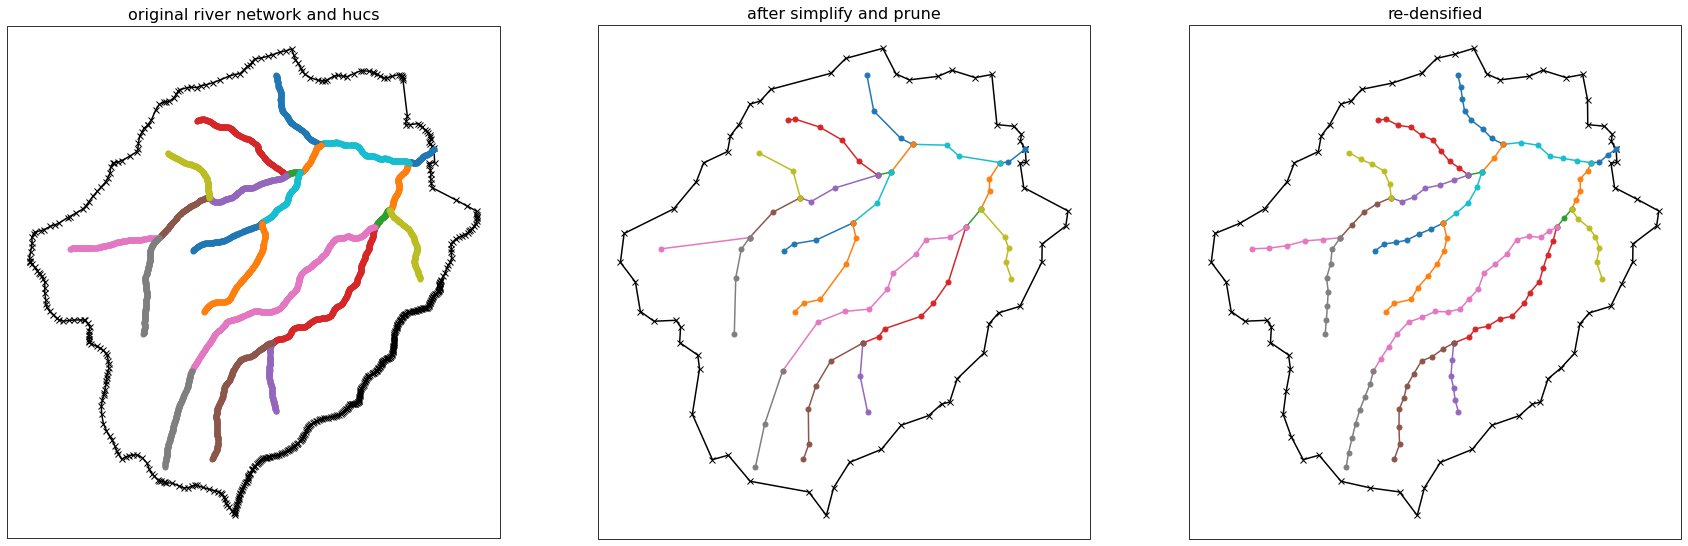

In [10]:
# plotting results
plt.rcParams['figure.figsize'] = [30, 20]

fig, axs = plt.subplots(1,3,subplot_kw={'projection':workflow.crs.to_cartopy(crs)})

axs[0].plot(watershed_.exterior().exterior.xy[0], watershed_.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)
axs[2].plot(watershed_densified.exterior().exterior.xy[0], watershed_densified.exterior().exterior.xy[1], 'k-x')
axs[2].set_title('re-densified',fontsize=16)
axs[2].plot()

for node in river_.preOrder():
    x,y=node.segment.xy # node.segment gives us LS
    axs[0].plot(x,y,'-o',markersize=5)

for node in river.preOrder():
    x,y=node.segment.xy # node.segment gives us LS
    axs[1].plot(x,y,'-o',markersize=5)

for node in river_densified.preOrder():
    x,y=node.segment.xy # node.segment gives us LS
    axs[2].plot(x,y,'-o',markersize=5)
  

## Meshing Begin

### Triangulation Leaving River-corridor Out

In [11]:
## **** River corridor polygon creation
delta=8 # river width  ## at some point, we need to make this river-order dependent
corr1, corr2, corr3 = workflow.river_tree.create_river_corridor(river_densified, delta)
corr = corr3

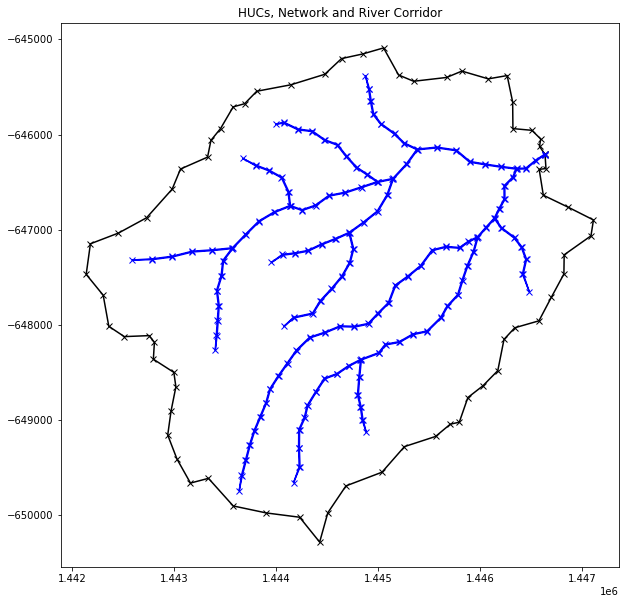

In [12]:
## plotting river corridor 
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.plot(watershed_densified.exterior().exterior.xy[0], watershed_densified.exterior().exterior.xy[1], 'k-x')
ax.plot(corr.exterior.xy[0], corr.exterior.xy[1], 'b-x')
plt.title('HUCs, Network and River Corridor')
plt.show()

In [13]:
## Triangulating the domain with river corridor polygon as a hole
kwargs = {'max_volume': 10000, 'allow_boundary_steiner': False}
points, elems= workflow.triangulation_with_streams.triangulate(watershed_densified, corr ,mixed=True ,tol=0.1, **kwargs)

2021-10-29 13:01:34,070 - root - INFO: Triangulating...
2021-10-29 13:01:34,071 - root - INFO: Adding river outlet in huc...
2021-10-29 13:01:34,073 - root - INFO:    344 points and 345 facets
2021-10-29 13:01:34,074 - root - INFO:  checking graph consistency
2021-10-29 13:01:34,074 - root - INFO:  tolerance is set to 0.1
2021-10-29 13:01:34,077 - root - INFO:  building graph data structures
2021-10-29 13:01:34,081 - root - INFO:  triangle.build...
2021-10-29 13:01:34,092 - root - INFO:   ...built: 1314 mesh points and 2282 triangles


maximum area of the traingle 39404.113953 , minimum area of the triangle 2836.505432 , number of triangles 2282


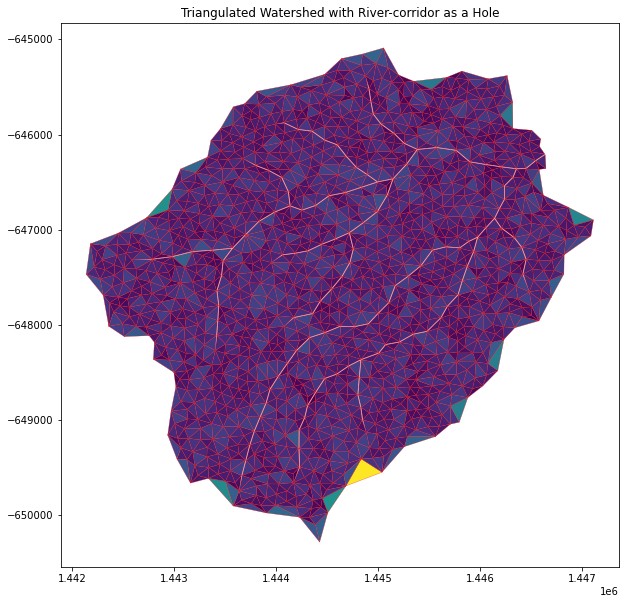

In [14]:
areas = np.array([workflow.utils.triangle_area(points[e]) for e in elems])
print('maximum area of the traingle', round(max(areas),6) ,', minimum area of the triangle', round(min(areas),6), ', number of triangles', len(areas))

plt.rcParams['figure.figsize'] = [10, 10]
plt.tripcolor(points[:,0], points[:,1], elems, areas, edgecolor='r')
plt.title('Triangulated Watershed with River-corridor as a Hole')
plt.show()

### Defining Quad-mesh-elements in River Corridor

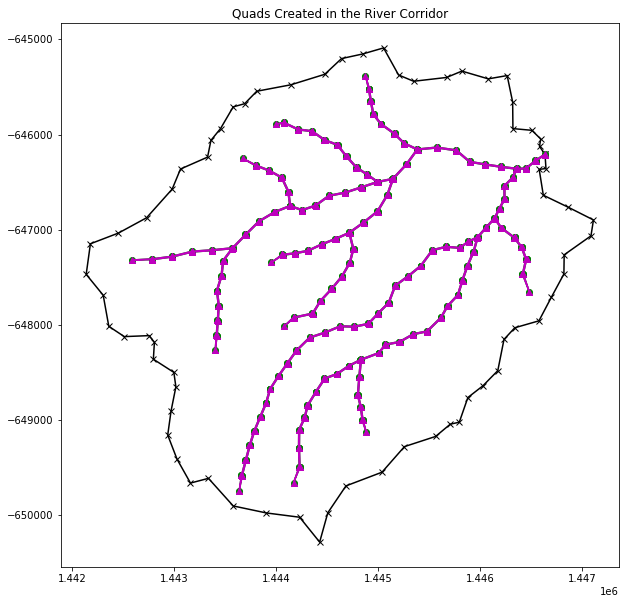

In [15]:
# defining quad elements from the river-corridor points
corr_coords=corr.exterior.coords[:-1]
fig = plt.figure(figsize=(10,10)) # this plotting is currently mandated in to_quad function
ax = fig.add_subplot(111)
ax.plot(watershed_densified.exterior().exterior.xy[0], watershed_densified.exterior().exterior.xy[1], 'k-x')
quads= workflow.river_tree.to_quads(river_densified, delta, watershed_densified, corr_coords,ax)
for elem in quads:
    looped_conn = elem[:]
    looped_conn.append(elem[0])
    cc = np.array([corr_coords[n] for n in looped_conn])
    ax.plot(cc[:,0], cc[:,1], 'm-^')
plt.title('Quads Created in the River Corridor')
plt.show()

In [16]:
# adding quad elements to the existing list of elements
elems_list=list(elems)
for elem in quads:
    elems_list.append(elem)

### Map mesh to DEM

In [17]:
# download the needed rasters
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2021-10-29 13:01:40,979 - root - INFO: 
2021-10-29 13:01:40,979 - root - INFO: Loading Raster
2021-10-29 13:01:40,980 - root - INFO: ------------------------------
2021-10-29 13:01:40,980 - root - INFO: Collecting raster
2021-10-29 13:01:41,002 - root - INFO: Collecting DEMs to tile bounds: [-83.48845037186388, 35.01734099944004, -83.41165773504302, 35.08381933600242]
2021-10-29 13:01:41,003 - root - INFO:   Need:
2021-10-29 13:01:41,004 - root - INFO:     /Users/7s2/Installations/ww_testing/watershed-workflow/examples/Coweeta/scripts/data/dem/USGS_NED_13as_n36_w084.tif
2021-10-29 13:01:42,027 - root - INFO: https://tnmaccess.nationalmap.gov/api/v1/products?datasets=National+Elevation+Dataset+%28NED%29+1%2F3+arc-second&bbox=-83.48845037186388%2C35.01734099944004%2C-83.41165773504302%2C35.08381933600242&prodFormats=GeoTIFF
2021-10-29 13:01:42,028 - root - INFO: Attempting to download source for target '/Users/7s2/Installations/ww_testing/watershed-workflow/examples/Coweeta/scripts/data/

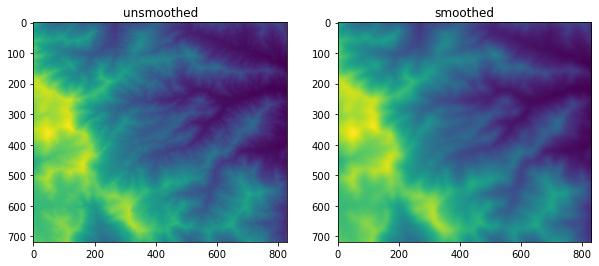

In [18]:
# noting that the DEM is a 10m raster
# the DEM will look quite rough.  Smooth a small amount.  Note better algorithms could be used 
# here, but for now we just use Gaussian smoothing.
dem_sm = scipy.ndimage.gaussian_filter(dem, 5, mode='nearest')
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(dem)
axs[0].set_title('unsmoothed')
axs[1].imshow(dem_sm)
txt = axs[1].set_title('smoothed')

In [28]:
crs = workflow.crs.daymet_crs()
mesh_points3 = workflow.elevate(points, crs, dem_sm, dem_profile)

2021-10-27 14:26:31,109 - root - INFO: 
2021-10-27 14:26:31,110 - root - INFO: Elevating Triangulation to DEM
2021-10-27 14:26:31,111 - root - INFO: ------------------------------


The block below can be used to manually lower the elevation in the river-corridors if the land-surface depression is not sufficiently captured in the DEM. For this example, we do not change any elevation.

In [84]:
## identifying the mesh points in the river corridor
#inds=points_on_in_rc(points, corr) # this function identifies points lying withing the river corridor
#inds=range(len(NodesEdges([corr]).nodes)) # here we use the information of river-corridor points directly
#mesh_points3[inds,2]=mesh_points3[inds,2]-2 # here we can lower the elevation for the river

In [29]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), elems_list)

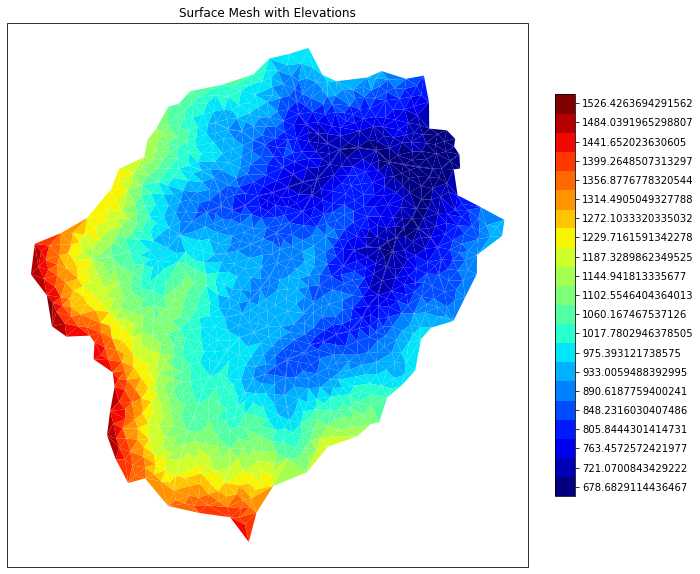

In [31]:
# plotting surface mesh with elevations
start=min(m2.centroids()[:,2])
step=(max(m2.centroids()[:,2])-(min(m2.centroids()[:,2])))/20
stop=max(m2.centroids()[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')
fig, ax = workflow.plot.get_ax(crs)
fig.set_size_inches(12, 10)

plt.rcParams['figure.figsize'] = [10, 10]
mp = workflow.plot.mesh(m2, crs=None, ax=ax, 
                        linewidth=2 ,color=m2.centroids()[:,2], 
                        cmap=cmap, norm = norm)

workflow.colors.colorbar_index(ncolors=len(legend_values), cmap=cmap, labels = labels) 
plt.title('Surface Mesh with Elevations')
plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed forest.

In [32]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-10-27 14:28:37,685 - root - INFO: 
2021-10-27 14:28:37,685 - root - INFO: Loading Raster
2021-10-27 14:28:37,686 - root - INFO: ------------------------------
2021-10-27 14:28:37,687 - root - INFO: Collecting raster
2021-10-27 14:28:37,697 - root - INFO: CRS: PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2021-10-27 14:28:37,750 - root - INFO: ... got raster of shape: (180, 173)
2021-10-27 14:28:37,761 - root - INFO: ... got raster bounds:

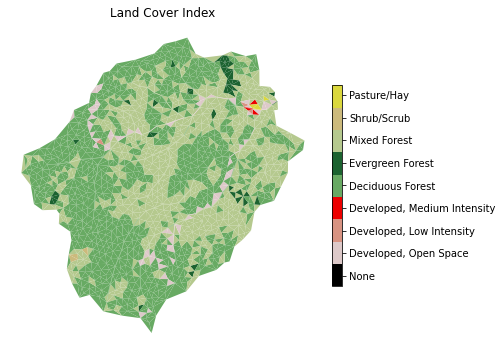

In [33]:
# plot the image
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ext = ax.axis('off')

In [34]:
# we don't really need all of these.  Keep Evergreen, Deciduous, Shrub, and merge the rest into "Other"
nlcd_color_new = 99 * np.ones_like(lc)

groupings = {
    43 : ['Mixed Forest', 'Evergreen Forest',],
    41 : ['Deciduous Forest',],
    81 : ['Dwarf Scrub', 'Shrub/Scrub', 'Grassland/Herbaceous', 'Sedge/Herbaceous', 
                     'Pasture/Hay', 'Cultivated Crops'],
}

for k,v in groupings.items():
    for label in v:
        index = sources['land cover'].indices[label]
        nlcd_color_new[np.where(lc == index)] = k
    
print(nlcd_color_new)

[41 41 41 ... 43 41 43]


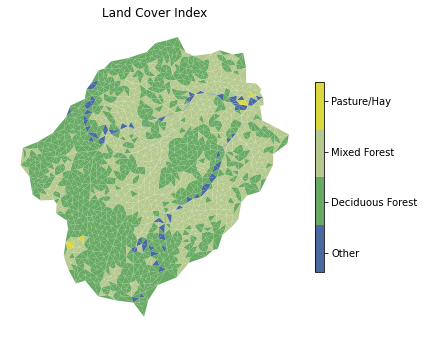

In [35]:
# plot the updated image, adding "other"
nlcd_color_new_other_as_water = np.where(nlcd_color_new == 99, 11, nlcd_color_new)

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(nlcd_color_new_other_as_water)

# make (water, 11) into (other, 99)
nlcd_labels[0] = 'Other'
nlcd_indices[0] = 99

fig, ax = workflow.plot.get_ax(crs, figsize=figsize)


polys = workflow.plot.mesh(m2, crs, ax=ax, color=nlcd_color_new_other_as_water, 
                           cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                        facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(nlcd_color_new_other_as_water)), 
                               cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ext = ax.axis('off')
plt.tight_layout()
#fig.savefig(get_filename('coweeta_landcover'))




## Subsurface properties

The default model uses GLHYMPS to identify geologic formations, and 

In [36]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
soil_profile, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], 
                                                                   target_bounds, crs, crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['mukey'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2021-10-27 14:28:59,644 - root - INFO: target bounds: (1442135.595488033, -650282.048183706, 1447110.5975158156, -645090.2638397965)
2021-10-27 14:28:59,645 - root - INFO: 
2021-10-27 14:28:59,646 - root - INFO: Loading shapes
2021-10-27 14:28:59,646 - root - INFO: ------------------------------
2021-10-27 14:28:59,696 - root - INFO: Attempting to download source for target '/Users/7s2/Installations/ww_testing/watershed-workflow/examples/Coweeta/scripts/data/soil_structure/SSURGO/SSURGO_-83.4848_35.0223_-83.4175_35.0793.shp'
2021-10-27 14:28:59,766 - root - INFO:   Found 652 shapes.
2021-10-27 14:28:59,776 - root - INFO:   and crs: epsg:4326
2021-10-27 14:28:59,785 - root - INFO: found 45 unique MUKEYs.
2021-10-27 14:29:02,061 - root - INFO: Running Rosetta for van Genutchen parameters
2021-10-27 14:29:02,062 - root - INFO:   database: /Users/7s2/Installations/ww_testing/watershed-workflow/workflow_tpls/rosetta/sqlite/Rosetta.sqlite
2021-10-27 14:29:02,062 - root - INFO:   model type: 

Select only the soils within the watershed

In [37]:
soil_survey_props.set_index('mukey', inplace=True, drop=False)
soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]

/Users/7s2/opt/anaconda3/envs/watershed_workflow_210126/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


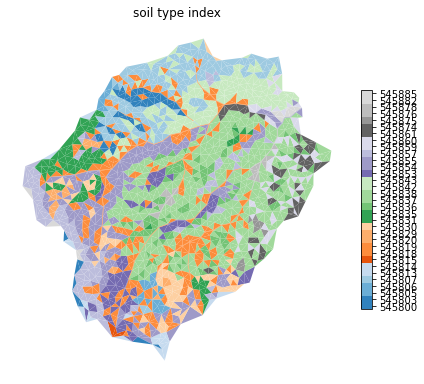

In [38]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels = labels) 

ax.set_title('soil type index')
ax.axis('off')
plt.tight_layout()
#fig.savefig(get_filename('coweeta_soils'))



Median soil thickness [-] =  2.03


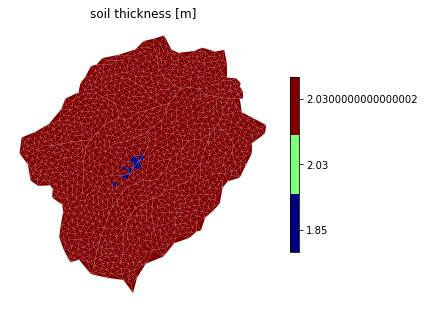

In [39]:
# what does soil thickness look like?
soil_thickness = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey,'thickness [cm]']

soil_thickness = soil_thickness / 100
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_thickness, cmap='jet')
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_thickness, 
                        cmap=cmap                       )
ax.set_title('soil thickness [m]')
workflow.colors.colorbar_index(ncolors=len(np.unique(soil_thickness)), cmap=cmap, labels = labels) 
ax.axis('off')
plt.tight_layout()

print('Median soil thickness [-] = ', np.nanmedian(soil_thickness))

Median porosity [-] =  0.37916256157635475


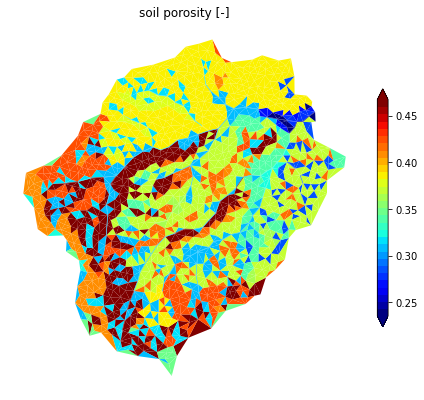

In [40]:
# plot of porosity from SSURGO
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(iprop, cmap='jet')
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
mp = workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0, color=iprop, cmap=cmap)
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
ax.axis('off')
plt.tight_layout()
#fig.savefig(get_filename('coweeta_soil_porosity'))

print('Median porosity [-] = ', np.nanmedian(iprop))

Min k [m^2] =  3.4290275210225e-15


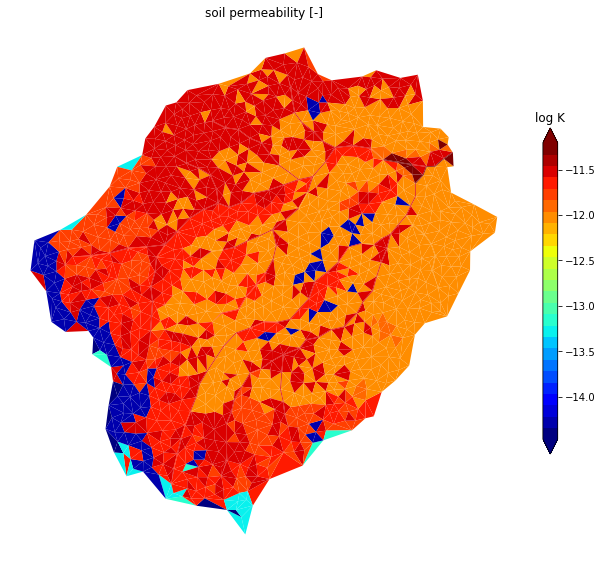

In [42]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']
    
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(np.log10(iprop), cmap='jet')
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0,color=np.log10(iprop),cmap=cmap)
ax.set_title('soil permeability [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')
#fig.savefig(get_filename('coweeta_soil_permeability'))

print('Min k [m^2] = ', np.nanmin(iprop))

In [43]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
soil_survey_props_clean = soil_survey_props.copy()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)


def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)
    
# drop nans
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)
soil_survey_props_clean



,residual saturation [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],native_index,thickness [m],permeability [m^2],porosity [-],source
0,0.177165,0.000139,1.470755,545800,2.03,3.429028e-15,0.307246,NRCS
1,0.172412,0.000150,1.491087,545803,2.03,2.800000e-12,0.379163,NRCS
2,0.177122,0.000083,1.468789,545805,2.03,2.800000e-12,0.384877,NRCS
3,0.177122,0.000083,1.468789,545806,2.03,2.800000e-12,0.384877,NRCS
4,0.177122,0.000083,1.468789,545807,2.03,2.800000e-12,0.384877,NRCS
5,0.183468,0.000127,1.445858,545813,2.03,6.219065e-14,0.349442,NRCS
6,0.183709,0.000126,1.444985,545814,2.03,5.999907e-14,0.344322,NRCS
7,0.178116,0.000161,1.496402,545815,2.03,4.813863e-14,0.314865,NRCS
8,0.177633,0.000153,1.480849,545818,2.03,2.912604e-12,0.305511,NRCS
9,0.180064,0.000150,1.470521,545819,2.03,2.906012e-12,0.313860,NRCS


/Users/7s2/opt/anaconda3/envs/watershed_workflow_210126/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(1441886.84485, 1447359.34815, -650541.6372, -644830.6747999999)

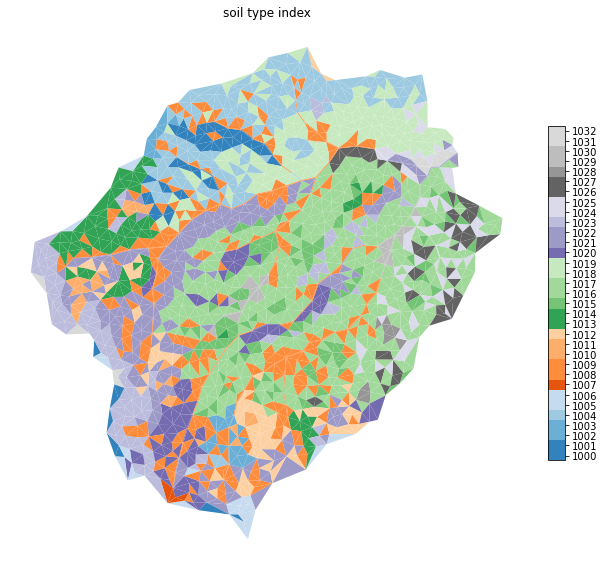

In [44]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukey in enumerate(soil_survey_props_clean['native_index']):
    soil_color_new[np.where(soil_color == mukey)] = 1000+new_id
    
# image the new soil_color
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color_new, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

### GLYHMPS geologic layer

GLYHMPS is complete in that it does not appear to have missing data, but does not have texture properties needed for Water Retention Models.  Instead we rely on scaling laws to fill the data.

In [45]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], 
                                                      target_bounds, crs, crs, properties=True)

# -- log the bounds targeted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)


2021-10-27 14:29:57,581 - root - INFO: target bounds: (1442135.595488033, -650282.048183706, 1447110.5975158156, -645090.2638397965)
2021-10-27 14:29:57,582 - root - INFO: 
2021-10-27 14:29:57,582 - root - INFO: Loading shapes
2021-10-27 14:29:57,583 - root - INFO: ------------------------------
2021-10-27 14:29:57,583 - root - INFO: Getting shapes of GLHYMPS on bounds: (1442135.595488033, -650282.048183706, 1447110.5975158156, -645090.2638397965)
2021-10-27 14:29:57,584 - root - INFO:   from file: /Users/7s2/Installations/ww_testing/watershed-workflow/examples/Coweeta/scripts/data/soil_structure/GLHYMPS/GLHYMPS.shp
2021-10-27 14:29:57,685 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
/Users/7s2/Installations/ww_testing/watershed-workflow/workflow/sources/manager_shape.py:85: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-10-27 14:30:14,819 - root

In [46]:
# select the properties that appear in the mesh
geo_survey_props.set_index('id', inplace=True, drop=False)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

(1441886.84485, 1447359.34815, -650541.6372, -644830.6747999999)

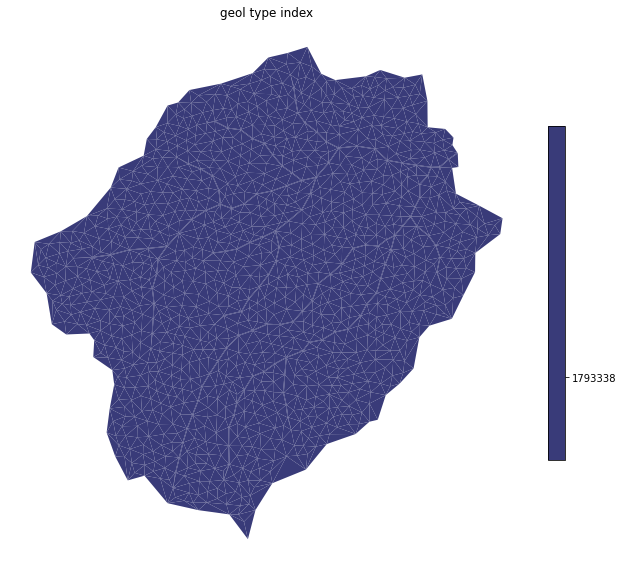

In [47]:
# plot the geologic formation id
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap='tab20b')

fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels=labels) 

ax.set_title('geol type index')
ax.axis('off')

(1441886.84485, 1447359.34815, -650541.6372, -644830.6747999999)

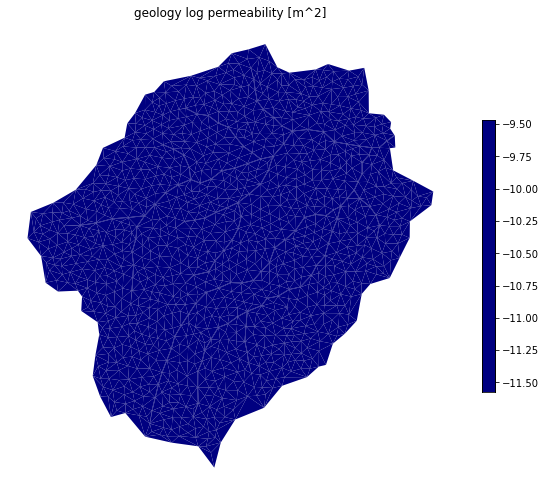

In [48]:
# plot permeability of the underlying geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
    
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(np.log10(iprop), cmap='jet')
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0,color=np.log10(iprop),cmap=cmap)
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology log permeability [m^2]')
ax.axis('off')


(1441886.84485, 1447359.34815, -650541.6372, -644830.6747999999)

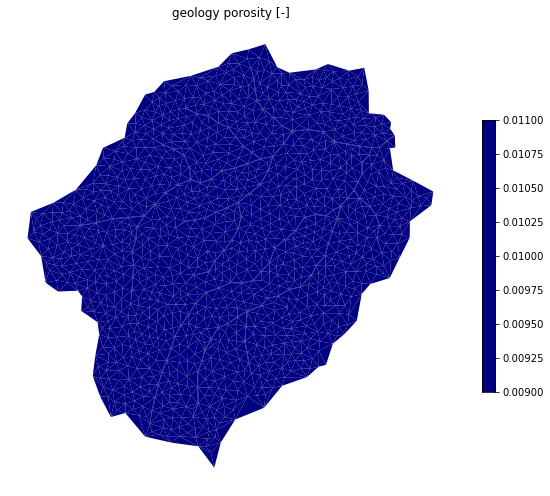

In [49]:
# plot porosity of the geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'porosity [-]']

indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(iprop, cmap='jet')
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0,color=iprop,cmap=cmap)
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology porosity [-]')
ax.axis('off')


In [50]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)


def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
geo_survey_props_clean

,native_index,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-]
0,"(1793338,)",GLHYMPS,3.019952e-11,0.01,0.023953,2.0,0.01


/Users/7s2/opt/anaconda3/envs/watershed_workflow_210126/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(1441886.84485, 1447359.34815, -650541.6372, -644830.6747999999)

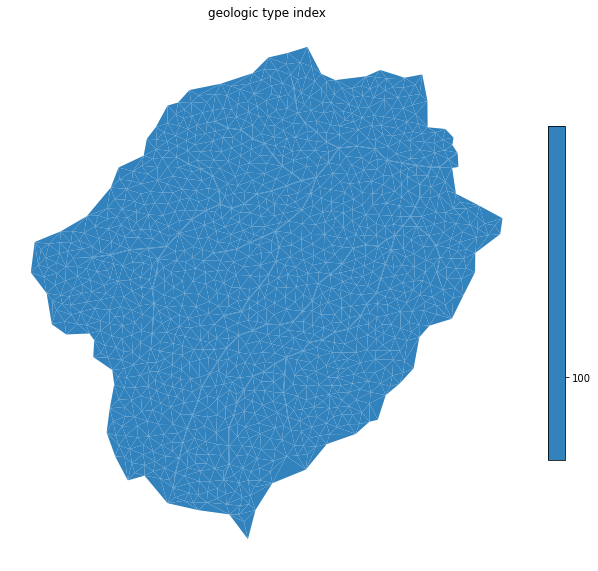

In [51]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+new_id
    
# image the new geo_color
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color_new, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

ax.set_title('geologic type index')
ax.axis('off')

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [52]:
DTB_source = workflow.source_list.structure_sources['SoilGrids2017']
DTB_profile, DTB_raster = workflow.get_raster_on_shape(DTB_source, watershed.exterior(), crs, 
                                                       nodata=-99999, variable='BDTICM')

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2021-10-27 14:31:24,989 - root - INFO: 
2021-10-27 14:31:24,990 - root - INFO: Loading Raster
2021-10-27 14:31:24,990 - root - INFO: ------------------------------
2021-10-27 14:31:24,991 - root - INFO: Collecting raster
2021-10-27 14:31:24,998 - root - INFO: CRS: EPSG:4326
2021-10-27 14:31:24,999 - root - INFO: filename: /Users/7s2/Installations/ww_testing/watershed-workflow/examples/Coweeta/scripts/data/soil_structure/SoilGrids2017/BDTICM_M_250m_ll.tif
2021-10-27 14:31:25,034 - root - INFO: bounds in my_crs: (-83.47845037186387, 35.027340999440035, -83.42165773504303, 35.07381933600242)
2021-10-27 14:31:25,076 - root - INFO: ... got raster of shape: (23, 28)
2021-10-27 14:31:25,084 - root - INFO: ... got raster bounds: (-83.47918210995822, 35.07417503397883, -83.42084878595819, 35.02625837497881)


Text(0.5, 1.0, 'DTB [m]')

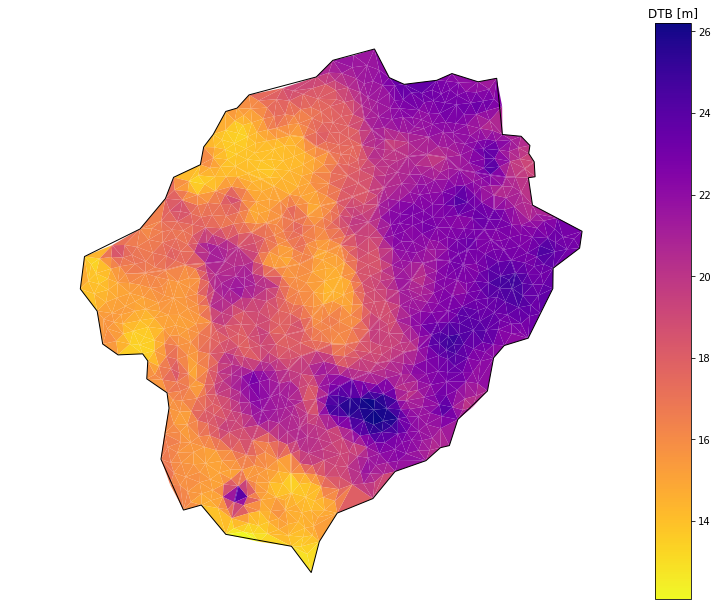

In [53]:
# plot the resulting surface mesh
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(DTB, cmap='plasma_r')
mp = workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0,color=DTB,cmap=cmap)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')

cbar.ax.set_title('DTB [m]')
#fig.savefig(get_filename('coweeta_dtb'))

## A combined, complete product?

As a default, we would like a material-driven (e.g. not fields for porosity, perm, etc, but soil classes, each with a common porosity/permeability/vG curve) default that is valid everywhere.  That makes it clear that we must rely on GLHYMPS as the only material-based product that is valid everywhere.  Other products may be layered on top of this, replacing GLHYMPS values, but the underlying layer should be based on GLHYMPS.  To fill in the van Genuchten properties, we relate alpha to permeability and choose a single common n and s_r.

Where available, we then choose to use SSURGO as a layer on top of GLHYMPS.  So start by using all GLHYMPS values, then override ones where SSURGO is valid with those values.  This will be the second model, and has then three layers -- a bedrock layer, a soil layer from 0 to 2m, and a geologic layer, using GLHYMPS values.  SoilGrids depth-to-bedrock will be used to provide the transition between bedrock and (where > 2m) the GLHYMPS "geologic" layer or (where < 2m) the SSURGO "soil" layer.  Where SSURGO has no values, the underlying GLHYMPS values will be used even in the top 2m.



## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs. 999 is reserved for bedrock.
* 1000-9999 : soil layer material IDs




In [54]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

bedrock_props = workflow.soil_properties.get_bedrock_properties()

# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])

# save the properties to disk for use in generating input file
#subsurface_props.to_csv(get_filename('Coweeta_subsurface_properties.csv'))
subsurface_props

,native_index,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],thickness [m]
ats_id,,,,,,,,
100,"(1793338,)",GLHYMPS,3.019952e-11,0.010000,0.023953,2.000000,0.010000,NaN
1000,545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,2.03
1001,545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,2.03
1002,545805,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,2.03
1003,545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,2.03
1004,545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,2.03
1005,545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,2.03
1006,545814,NRCS,5.999907e-14,0.344322,0.000126,1.444985,0.183709,2.03
1007,545815,NRCS,4.813863e-14,0.314865,0.000161,1.496402,0.178116,2.03


Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [55]:
# here we choose the bottom of the domain to be bigger than the maximum of the depth to bedrock.  
# This is really up to the user...
total_thickness = np.ceil(DTB.max())
print(f'total thickness: {total_thickness} m')

total_thickness = 41.0

total thickness: 27.0 m


In [56]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.0500016  0.05030145 0.06625834 0.1110568  0.22600204 0.49640501
 0.49997989 0.49999487]
2.0


In [57]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [58]:
# 41m total thickness, minus 2m soil thickness, leaves us with 39 meters to make up.
# optimize again...
dzs2, res2 = workflow.mesh.optimize_dzs(1, 10, 39, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 3.0,] + 7*[5.0,]
print(dzs_geo)
print(sum(dzs_geo))

[ 1.43810942  2.49456441  5.06733261  9.99999356  9.99999999 10.        ]
39.0
[1.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
39.0


In [59]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    br_or_geo = np.where(depth < DTB, geo_color_new, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(np.where(depth < DTB, geo_color_new, 999))
    depth += 0.5 * dz

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-10-27 14:32:31,549 - root - INFO: Cell summary:
2021-10-27 14:32:31,549 - root - INFO: ------------------------------------------------------------
2021-10-27 14:32:31,550 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-10-27 14:32:31,550 - root - INFO: ------------------------------------------------------------
2021-10-27 14:32:31,551 - root - INFO:  00 	| 00 	| 1006 	|   0.050000 	|   0.000000
2021-10-27 14:32:31,551 - root - INFO:  01 	| 01 	| 1006 	|   0.050000 	|   0.050000
2021-10-27 14:32:31,552 - root - INFO:  02 	| 02 	| 1006 	|   0.050000 	|   0.100000
2021-10-27 14:32:31,552 - root - INFO:  03 	| 03 	| 1006 	|   0.120000 	|   0.150000
2021-10-27 14:32:31,553 - root - INFO:  04 	| 04 	| 1006 	|   0.230000 	|   0.270000
2021-10-27 14:32:31,553 - root - INFO:  05 	| 05 	| 1006 	|   0.500000 	|   0.500000
2021-10-27 14:32:31,553 - root - INFO:  06 	| 06 	| 1006 	|   0.500000 	|   1.000000
2021-10-27 14:32:31,554 - root - INFO:  07 	| 07 	| 1006 	|   0.500000 	|   1.5

In [62]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [63]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(nlcd_color_new == index)[0]
    print(index, name, len(where))
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

99 Other 91
41 Deciduous Forest 1291
43 Mixed Forest 1042
81 Pasture/Hay 7


In [65]:
# save to disk
try:
    os.remove(get_filename('Coweeta_mixed_elements.exo'))
except FileNotFoundError:
    pass
m3.write_exodus(get_filename('Coweeta_mixed_elements.exo'))

Opening exodus file: ../workflow_output/Coweeta_mixed_elements.exo
Closing exodus file: ../workflow_output/Coweeta_mixed_elements.exo
